<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук НИУ ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее  задание № 8</center>
## <center>Классификация отзывов к фильмам с помощью Vowpal Wabbit или sklearn.linear_model.SGDClassifier</center>

**Ранее рассматривались решения этой задачи с помощью логистической регрессии и линейного SVM, задача этого задания – увидеть, как с помощью ненастроенного Vowpal Wabbit можно быстро получить примерную по качеству модель классификации отзывов. Также в задании можно использовать линейный классификатор, обучаемый стохастическим градиентным спуском, sklearn.linear_model.SGDClassifier, но в таком случаем максимум за задание можно получить 7 баллов.**

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import numpy as np
import re
import os
from subprocess import check_output
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

Populating the interactive namespace from numpy and matplotlib


**Используйте функцию *load_files* из sklearn.datasets для загрузки отзывов по фильмам [отсюда](https://yadi.sk/d/Tg1Tflur333iLr) (архив с большим числом файлов, моежт долго раскрываться). В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам. Отделите данные (собственно тексты) от меток.**

In [2]:
reviews_train = load_files('../../data/aclImdb/train')
text_train, y_train = reviews_train.data, reviews_train.target

In [3]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


**Сделайте то же самое с тестовой выборкой.**

In [4]:
reviews_test = load_files('../../data/aclImdb/test')
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


**Пример отзыва и соответствующей метки.**

In [10]:
text_train[1]

'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulence

In [11]:
y_train[1] # плохой отзыв

0

In [12]:
text_train[2]

'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [13]:
y_train[2] # хороший отзыв

1

**Будем использовать ранее написанную функцию vowpalize.**

In [14]:
def vowpalize(document, label=None):
    return str(str(label) or '') + ' |text ' + ' '.join(re.findall('\w{3,}', str(document).lower())) + '\n'

In [15]:
vowpalize(text_train[1], 1 if y_train[0] == 1 else -1)

'1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regarding the airplane won list them here but just mention the coloring the plane they didn even manage show airliner the colors fictional airline but instead used 747 painted the original boeing livery very bad the plot stupid and has been done many times before only much much better there are many ridiculous moments here that lost count really early also was the bad guys side all the time the movie because the good guys were stupid executive decision should without doubt you choice over this one even the turbulence movies are better fact every other movie the world better than this one\n'

**Подготовьте обучающую (../../output/movie_reviews_train.vw) и тестовую (../../output/movie_reviews_test.vw) выборки для Vowpal Wabbit.**

In [21]:
with open('../../output/movie_reviews_train.vw', 'w') as vw_train_data:
    for text, target in zip(text_train, y_train):
        vw_train_data.write(vowpalize(text, 1 if target == 1 else -1))
        
        
with open('../../output/movie_reviews_test.vw', 'w') as vw_test_data:
    for text in text_test:
        vw_test_data.write(vowpalize(text))

**Обучите модель Vowpal Wabbit. Передайте следующие агрументы:**

 - -d, путь к обучающей выборке (соотв. файл .vw )
 - --loss_function – Hinge (хотя можно и поэкспериментировать с другими)
 - -f – путь к файлу, в который запишется модель (можно тоже в формате .vw)

Поэкспериментировал и получилось, что AUC подрастает на 0.09, если использовать логистическую функцию потерь. А вот регуляризация очень сильно снижает качество, даже если брать l1 с 0.000001

In [40]:
!vw -d ../../output/movie_reviews_train.vw --loss_function logistic -f ../../output/movie_reviews_model.vw

final_regressor = ../../output/movie_reviews_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../output/movie_reviews_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0   1.0000   0.0000      105
1.151437 1.609728            2            2.0  -1.0000   1.3867      162
0.965289 0.779140            4            4.0  -1.0000  -0.0169      110
0.773629 0.581970            8            8.0  -1.0000  -0.7304      219
1.027362 1.281095           16           16.0   1.0000   1.3665      204
0.885799 0.744235           32           32.0   1.0000   0.6629      190
0.944389 1.002980           64           64.0  -1.0000   0.4217      126
0.790956 0.637522          128          128.0  -1.0000  -1.5580      106
0.704507 0.618058          256          256.0  -1.0000  -1.83

Сделайте прогноз для тестовой выборки с помощью обученной модели Vowpal Wabbit. Передайте следующие аргументы:
 - -i –путь к обученной модели (соотв. файл .vw)
 - -t -d – путь к тестовый выборке (соотв. файл .vw)
 - -p – путь к txt-файлу, куда запишутся прогнозы

In [41]:
!vw -i ../../output/movie_reviews_model.vw -t -d ../../output/movie_reviews_test.vw -p ../../output/movie_reviews_predictions.txt

only testing
predictions = ../../output/movie_reviews_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../output/movie_reviews_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.244761 0.244761 war           1n i           1.0n g  0.0000:    0.4947N o      59n
e i3.063692s  5.882623n o           2t             2.0a    0.0000good float, repl a -2.42cing with 0
54      103
4.506196 5.948700warning: None is         not a good float, replacing with 0
    4            4.0   0.000warning: None is not a good float, replacing with 0
0  -3.0297      1warning: None is not a good float, replacing with 0
61
            8.0 warn  0.0000i n -2.5178g :     361 
None is not a good float, replacing with 0
8.247760 10.748240           16          warning: None is not a good float, replacing with 0
 16.0   0.0000 

**Посчитайте долю правильных ответов на тестовой выборке. Учтите, что Vowpal Wabbit прогнозирует числа в интервале [-1,1] – из надо превратить в бинарные прогнозы.**

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
import sklearn

In [44]:
test_predicted_labels = [float(label) 
                         for label in open('../../output/movie_reviews_predictions.txt').readlines()]

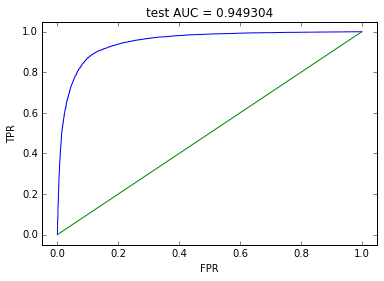

In [45]:
auc = sklearn.metrics.roc_auc_score(y_test, test_predicted_labels)
roc_curve = sklearn.metrics.roc_curve(y_test, test_predicted_labels)

plt.plot(roc_curve[0], roc_curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

In [47]:
round(accuracy_score(y_test, [int(pred_prob > 0) for pred_prob in test_predicted_labels]), 3)

0.887

Действительно неплохое качество получилось :) 